# 과적합 해결

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

### 배치 정규화 적용

In [66]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

In [67]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [68]:
class SimpleNN(nn.Module):
    def __init__(self, use_bn=False):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.bn1 = nn.BatchNorm1d(128) if use_bn else nn.Identity()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) if use_bn else nn.Identity()
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [69]:
def train(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(images.size(0), -1)
            outputs = model(images)
            val_loss = criterion(outputs, labels).item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            
    print(f'Epoch { epoch + 1 } | Val Loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / len(val_data):.4f}')    

In [70]:
print('배치 정규화 적용 안함')
model_without_bn = SimpleNN(use_bn=False)
train(model_without_bn, train_loader, val_loader)

print()
print('배치 정규화 적용')
model_with_bn = SimpleNN(use_bn=True)
train(model_with_bn, train_loader, val_loader)


배치 정규화 적용 안함
Epoch 5 | Val Loss: 0.0011, Accuracy: 0.9623

배치 정규화 적용
Epoch 5 | Val Loss: 0.0000, Accuracy: 0.9728


In [71]:
for batch_size in [16, 32, 128]:
    print(f'batch size: { batch_size }')
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    model = SimpleNN(use_bn=True)
    train(model, train_loader, val_loader)

batch size: 16
Epoch 5 | Val Loss: 0.0001, Accuracy: 0.9741
batch size: 32
Epoch 5 | Val Loss: 0.0002, Accuracy: 0.9762
batch size: 128
Epoch 5 | Val Loss: 0.0003, Accuracy: 0.9748


### 드롭아웃 적용

In [72]:
class DropoutNN(nn.Module):
    def __init__(self, dropout_rate):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.dropout1(self.fc1(x)))
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [73]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

for rate in [0.2, 0.5, 0.8]:
    print(f'Dropout Rate: { rate }')
    model = DropoutNN(dropout_rate=rate)
    train(model, train_loader, val_loader)

Dropout Rate: 0.2
Epoch 5 | Val Loss: 0.0002, Accuracy: 0.9653
Dropout Rate: 0.5
Epoch 5 | Val Loss: 0.0005, Accuracy: 0.9337
Dropout Rate: 0.8
Epoch 5 | Val Loss: 0.0056, Accuracy: 0.7206


In [74]:
model = DropoutNN(dropout_rate=0.2)

In [75]:
model.eval()
with torch.no_grad():
    images, _ = next(iter(val_loader))
    images = images.view(images.size(0), -1)
    
    out1 = model(images)
    out2 = model(images)
    
    print(torch.allclose(out1, out2))

True


In [76]:
model.train()

out1 = model(images)
out2 = model(images)

print(torch.allclose(out1, out2))

False


### Learning Rate Scheduler 적용

In [77]:
class RealSimpleNN(nn.Module):
    def __init__(self):
        super(RealSimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [78]:
def train_lr(model, train_loader, val_loader, optimizer, scheduler, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(images.size(0), -1)
            outputs = model(images)
            val_loss = criterion(outputs, labels).item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            
    scheduler.step()
    print(f'Epoch { epoch + 1 } | Val Loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / len(val_data):.4f}')

In [79]:
model = RealSimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

train_lr(model, train_loader, val_loader, optimizer, scheduler)

Epoch 5 | Val Loss: 0.0004, Accuracy: 0.9647


/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


### 조기 종료

In [80]:
def train_es(model, train_loader, val_loader, optimizer, epochs=50, early_stopping=None):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            accuracy = correct / len(val_data)
            
            print(f'Epoch {epoch + 1} | Val Loss: {val_losses}, Accuracy: {accuracy:.4f}')
        
        return train_losses, val_losses

In [81]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        
        else:
            self.counter += 1
            
        return self.counter >= self.patience

In [82]:
model_no_es = RealSimpleNN()
optim_no_es = optim.Adam(model_no_es.parameters(), lr=0.01)
train_losses, val_losses = train_es(model_no_es, train_loader, val_loader, optim_no_es)
model_es = RealSimpleNN()
optim_es = optim.Adam(model_es.parameters(), lr=0.01)
early_stopping = EarlyStopping(patience=5)
train_es_losses, val_es_losses = train_es(model_es, train_loader, val_loader, optim_es, early_stopping=early_stopping)

Epoch 1 | Val Loss: [0.26309076276548365], Accuracy: 0.9251
Epoch 1 | Val Loss: [0.2980357335008522], Accuracy: 0.9090


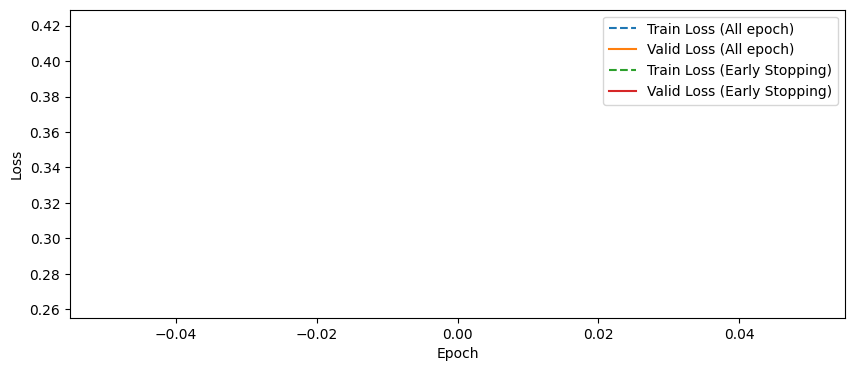

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss (All epoch)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (All epoch)')
plt.plot(train_es_losses, label='Train Loss (Early Stopping)', linestyle='dashed')
plt.plot(val_es_losses, label='Valid Loss (Early Stopping)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### L2 적용

In [84]:
def train_reg(model, train_loader, val_loader, optimizer, epochs=50):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    weight_norms = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            accuracy = correct / len(val_data)
            
            print(f'Epoch {epoch + 1} | Val Loss: {val_losses}, Accuracy: {accuracy:.4f}')
        
            weight_norm = sum(torch.norm(p).item() for p in model.parameters())
            weight_norms.append(weight_norm)
                    
        return train_losses, val_losses

In [85]:
model_no_reg = RealSimpleNN()
optim_no_reg = optim.SGD(model_no_reg.parameters(), lr=0.01, weight_decay=0.0, momentum=0.9)
train_losses, val_losses, weight_norms = train_reg(model_no_reg, train_loader, val_loader, optim_no_reg)

model_reg = RealSimpleNN()
optim_reg = optim.SGD(model_reg.parameters(), lr=0.01, weight_decay=0.01, momentum=0.9)
train_reg_losses, val_reg_losses, weight_norms_reg = train_reg(model_reg, train_loader, val_loader, optim_reg)


Epoch 1 | Val Loss: [0.24113813215034438], Accuracy: 0.9283


ValueError: not enough values to unpack (expected 3, got 2)